## Exercise 1: Simulation Helper Functions

The simulation setup — creating the fly, the world, and running the physics loop — is reused throughout this notebook. In this exercise, we encapsulate it in a reusable function. Refer to [the kinematic replay notebook](kinematic_replay.ipynb) for guidance.

In [ ]:
import re
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import yaml
from tqdm import trange

from flygym import Simulation, assets_dir
from flygym.anatomy import ActuatedDOFPreset, AxisOrder, JointPreset, Skeleton
from flygym.compose import ActuatorType, FlatGroundWorld, Fly
from flygym.compose.fly import DEFAULT_MUJOCO_GLOBALS_PATH
from flygym.compose.pose import KinematicPose
from flygym.utils.math import Rotation3D

# Load default simulation timestep from MuJoCo configuration
with open(DEFAULT_MUJOCO_GLOBALS_PATH) as f:
    mujoco_globals = yaml.safe_load(f)

sim_timestep = mujoco_globals["option"]["timestep"]

In [ ]:
def run_simulation(
    dof_angles: np.ndarray = None,
    dof_names: Iterable[str] = None,
    position_gain: float = 50,
    warmup_steps: int = 500,
    spawn_position: tuple = (0, 0, 0.7),
    spawn_rotation: Rotation3D = Rotation3D("quat", (1, 0, 0, 0)),
    axis_order: AxisOrder = AxisOrder.YAW_PITCH_ROLL,
    joint_preset: JointPreset = JointPreset.LEGS_ONLY,
    dof_preset: ActuatedDOFPreset = ActuatedDOFPreset.LEGS_ACTIVE_ONLY,
    actuator_type: ActuatorType = ActuatorType.POSITION,
    neutral_pose_path=assets_dir / "model/pose/neutral.yaml",
    playback_speed: float = 0.2,
    output_fps: int = 25,
    camera_kwargs: dict = None,
) -> Simulation:
    """Build a fly simulation, optionally replay DoF angles, and return it.

    If *dof_angles* is ``None`` the simulation is created but no physics
    steps are executed, which is useful for launching the interactive viewer.

    Parameters
    ----------
    dof_angles : np.ndarray, optional
        Joint-angle trajectory of shape ``(n_steps, n_dofs)`` in radians.
    dof_names : Iterable[str], optional
        DoF names matching the columns of *dof_angles* (used for reordering).
    position_gain : float
        Proportional gain (kp) of the position actuators.
    warmup_steps : int
        Number of physics steps to let the fly settle before replaying.
    camera_kwargs : dict, optional
        Extra keyword arguments forwarded to ``fly.add_tracking_camera()``.
    """
    ##########################################################################
    # TODO: create the fly, add joint, actuators and colors
    fly = ...

    skeleton = ...
    neutral_pose = ...
    fly.add_joints(
        ...
    )

    actuated_dofs = ...
    fly.add_actuators(
        ...
    )

    fly.colorize()
    ##########################################################################

    tracking_cam = fly.add_tracking_camera(**(camera_kwargs or {}))

    ##########################################################################
    # TODO: create the world, add the fly to it, and create the simulation
    world = ...
    world.add_fly(...)

    sim = ...

    sim.set_renderer(
        ...
    )
    ##########################################################################

    # If no control inputs provided, return the (un-stepped) simulation
    if dof_angles is None:
        return sim

    # Reorder columns from data ordering to simulation actuator ordering
    if dof_names is None:
        dof_angles_sorted = dof_angles
    else:
        sim_dof_order = [
            dof.name for dof in fly.get_actuated_jointdofs_order(actuator_type)
        ]
        dof_names = [str(dof) for dof in dof_names]
        reorder_idx = [dof_names.index(dof) for dof in sim_dof_order]
        dof_angles_sorted = dof_angles[:, reorder_idx]

    n_sim_steps = len(dof_angles)

    ############################################################################
    # TODO: run the physics loop, applying control inputs at each step after the
    # warmup and render each step
    for step in trange(warmup_steps + n_sim_steps):
        if step >= warmup_steps:
            control_inputs = ...
            sim.set_actuator_inputs(...)

        sim.step()
        sim.render_as_needed()

    return sim


def show_video(sim: Simulation, title: str = None):
    """Display the first renderer's video inline in the notebook."""
    sim.renderer.show_in_notebook(title=title)

In [ ]:
from scipy.interpolate import interp1d


def interpolate_dof_angles(
    dof_angles: np.ndarray,
    original_timestep: float,
    new_timestep: float,
) -> np.ndarray:
    """Resample DoF-angle trajectories to a new timestep via linear interpolation.

    Parameters
    ----------
    dof_angles : np.ndarray
        Joint angles of shape ``(n_frames, n_dofs)``.
    original_timestep : float
        Time between consecutive frames in the source data (seconds).
    new_timestep : float
        Desired time between frames after resampling (seconds).
    """
    original_time = np.arange(len(dof_angles)) * original_timestep
    new_time = np.arange(0, original_time[-1], new_timestep)
    interpolator = interp1d(original_time, dof_angles, axis=0)
    return interpolator(new_time)

In [ ]:
# Load experimentally recorded joint kinematics
data = np.load(assets_dir / "demo" / "210902_pr_fly1.npz")
recording_fps = data["fps"]
dof_angles = data["dof_angles"]  # shape: (n_frames, n_dofs)
dof_names = [str(name) for name in data["dof_order"]]

# Resample from recording rate to simulation rate
dof_angles_interp = interpolate_dof_angles(
    dof_angles,
    original_timestep=1 / recording_fps,
    new_timestep=sim_timestep,
)

## Exercise 2: Exploring the Effects of Simulation Parameters

In this exercise, we adjust the `position_gain` (proportional gain of the position actuator) and observe its impact on *Drosophila* locomotion.

Modify the cell below to run simulations with different values of `position_gain`. What happens when the gain is too low or too high?

In [ ]:
##############################################################################
# TODO: choose a few position gains (low, medium, high) and compare results
position_gains = [...]
##############################################################################

for gain in position_gains:
    sim = run_simulation(
        dof_angles=dof_angles_interp,
        dof_names=dof_names,
        position_gain=gain,
    )
    show_video(sim, title=f"Position Gain: {gain}")

## Exercise 3: Extracting a Single Walking Cycle

We extract a canonical walking cycle that can be tiled indefinitely for open-loop locomotion. The approach:

1. **Detect peaks** in a reference joint angle to delimit individual cycles.
2. **Resample** each cycle to a common length.
3. **Average** across cycles to obtain a smooth, repeatable template.

In [ ]:
from scipy.signal import find_peaks

# Extract a reference signal: right hind tibia pitch angle
rh_tibia_pitch = dof_angles[:, dof_names.index("rh_trochanterfemur-rh_tibia-pitch")]

################################################################################
# TODO: find the indices of the frames where the right hind tibia pitch reaches
# its local maxima (i.e., peaks) using scipy.signal.find_peaks
peak_frame_indices = ...
################################################################################

# Plot the signal with detected peaks
recording_timestep = 1 / recording_fps
time_s = np.arange(len(rh_tibia_pitch)) * recording_timestep

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(time_s, rh_tibia_pitch, color="C5")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Angle (rad)")
ax.set_title("Right hind tibia pitch")
for t_peak in time_s[peak_frame_indices]:
    ax.axvline(t_peak, color="k", ls="--", alpha=0.3)

In [ ]:
from itertools import pairwise
from scipy.interpolate import interp1d

# Number of simulation frames per cycle (average cycle duration / sim timestep)
mean_cycle_duration_s = np.diff(peak_frame_indices).mean() / recording_fps
cycle_n_frames = round(mean_cycle_duration_s / sim_timestep)

# Resample each cycle to a common length and accumulate
dof_angles_cycle = np.zeros((cycle_n_frames, len(dof_names)))
for start, end in pairwise(peak_frame_indices):
    old_idx = np.arange(end - start)
    new_idx = np.linspace(0, old_idx[-1], cycle_n_frames, endpoint=False)
    dof_angles_cycle += interp1d(old_idx, dof_angles[start:end], axis=0)(new_idx)

# Average over all cycles
dof_angles_cycle /= len(peak_frame_indices) - 1

In [ ]:
def flip_side(dof_name: str) -> str:
    """Swap 'l' ↔ 'r' prefixes in a DoF name to mirror it across the body midline."""
    leg1, seg1, leg2, seg2, angle_name = re.match(
        r"(.+)_(.+)-(.+)_(.+)-(.+)", dof_name
    ).groups()
    swap = {"l": "r", "r": "l"}
    leg1_flipped = swap.get(leg1[0], leg1[0]) + leg1[1:]
    leg2_flipped = swap.get(leg2[0], leg2[0]) + leg2[1:]
    return f"{leg1_flipped}_{seg1}-{leg2_flipped}_{seg2}-{angle_name}"

In [ ]:
# Symmetrise: average each cycle with its left-right mirror shifted by half a cycle
flipped_idx = [dof_names.index(flip_side(name)) for name in dof_names]
dof_angles_cycle_flipped = np.roll(dof_angles_cycle, shift=cycle_n_frames // 2, axis=0)[
    :, flipped_idx
]
dof_angles_cycle = (dof_angles_cycle + dof_angles_cycle_flipped) / 2

In [ ]:
LEG_NAMES = ["lf", "lm", "lh", "rf", "rm", "rh"]
SIDE_LABELS = {"l": "Left", "r": "Right"}
POSITION_LABELS = {"f": "front", "m": "middle", "h": "hind"}

fig, axes = plt.subplots(
    3, 2, figsize=(6.5, 6), sharex=True, sharey=True, tight_layout=True
)

# Plot each DoF angle (tiled for two cycles) on the corresponding leg subplot
for dof_name, cycle_angles in zip(dof_names, dof_angles_cycle.T):
    seg1, leg, seg2, angle_type = re.match(r".+_(.+)-(.+)_(.+)-(.+)", dof_name).groups()
    ax = axes.T.ravel()[LEG_NAMES.index(leg)]
    angles_deg = np.tile(np.rad2deg(cycle_angles), 2)
    time_s = np.arange(len(angles_deg)) * sim_timestep
    ax.plot(time_s, angles_deg, label=f"{seg1}-{seg2} {angle_type}")

# Format subplots
for leg, ax in zip(LEG_NAMES, axes.T.ravel()):
    ax.set_title(f"{SIDE_LABELS[leg[0]]} {POSITION_LABELS[leg[1]]} leg")
    ax.set_ylim(-180, 180)
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (°)")
    ax.axvline(cycle_n_frames * sim_timestep, color="k", ls="--", alpha=0.3)

axes[0, 1].legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

In [ ]:
n_cycles = 10
sim = run_simulation(
    ############################################################################
    # TODO: repeat the canonical cycle n_cycles times (hint: np.tile)
    dof_angles=...,
    ############################################################################
    dof_names=dof_names,
)
show_video(sim)

## Exercise 4: Altering Locomotor Kinematics

Can you make the fly walk approximately **twice as fast** using the same simulation parameters and number of steps?

> In *Drosophila*, walking speed is primarily regulated by changes in stance duration, while stance amplitude and swing duration remain relatively constant (DeAngelis et al., 2019; Wosnitza et al., 2012). For simplicity, we decrease both stance and swing durations here.

In [ ]:
sim = run_simulation(
    ############################################################################
    # TODO: make the fly walk ~2x faster by sub-sampling every other frame
    dof_angles=dof_angles_interp[...],
    ############################################################################
    dof_names=dof_names,
)
show_video(sim)

Can you make the fly walk **backwards**?

In [ ]:
sim = run_simulation(
    ############################################################################
    # TODO: make the fly walk backwards by reversing the trajectory
    dof_angles=dof_angles_interp[...],
    ############################################################################
    dof_names=dof_names,
)
show_video(sim)

## Exercise 5: Engineering New Behaviours

Realistic walking kinematics require multi-view recordings and 3D pose estimation. For simpler behaviours, however, we can design joint-angle keyframes by hand using the MuJoCo interactive viewer, then interpolate between them.

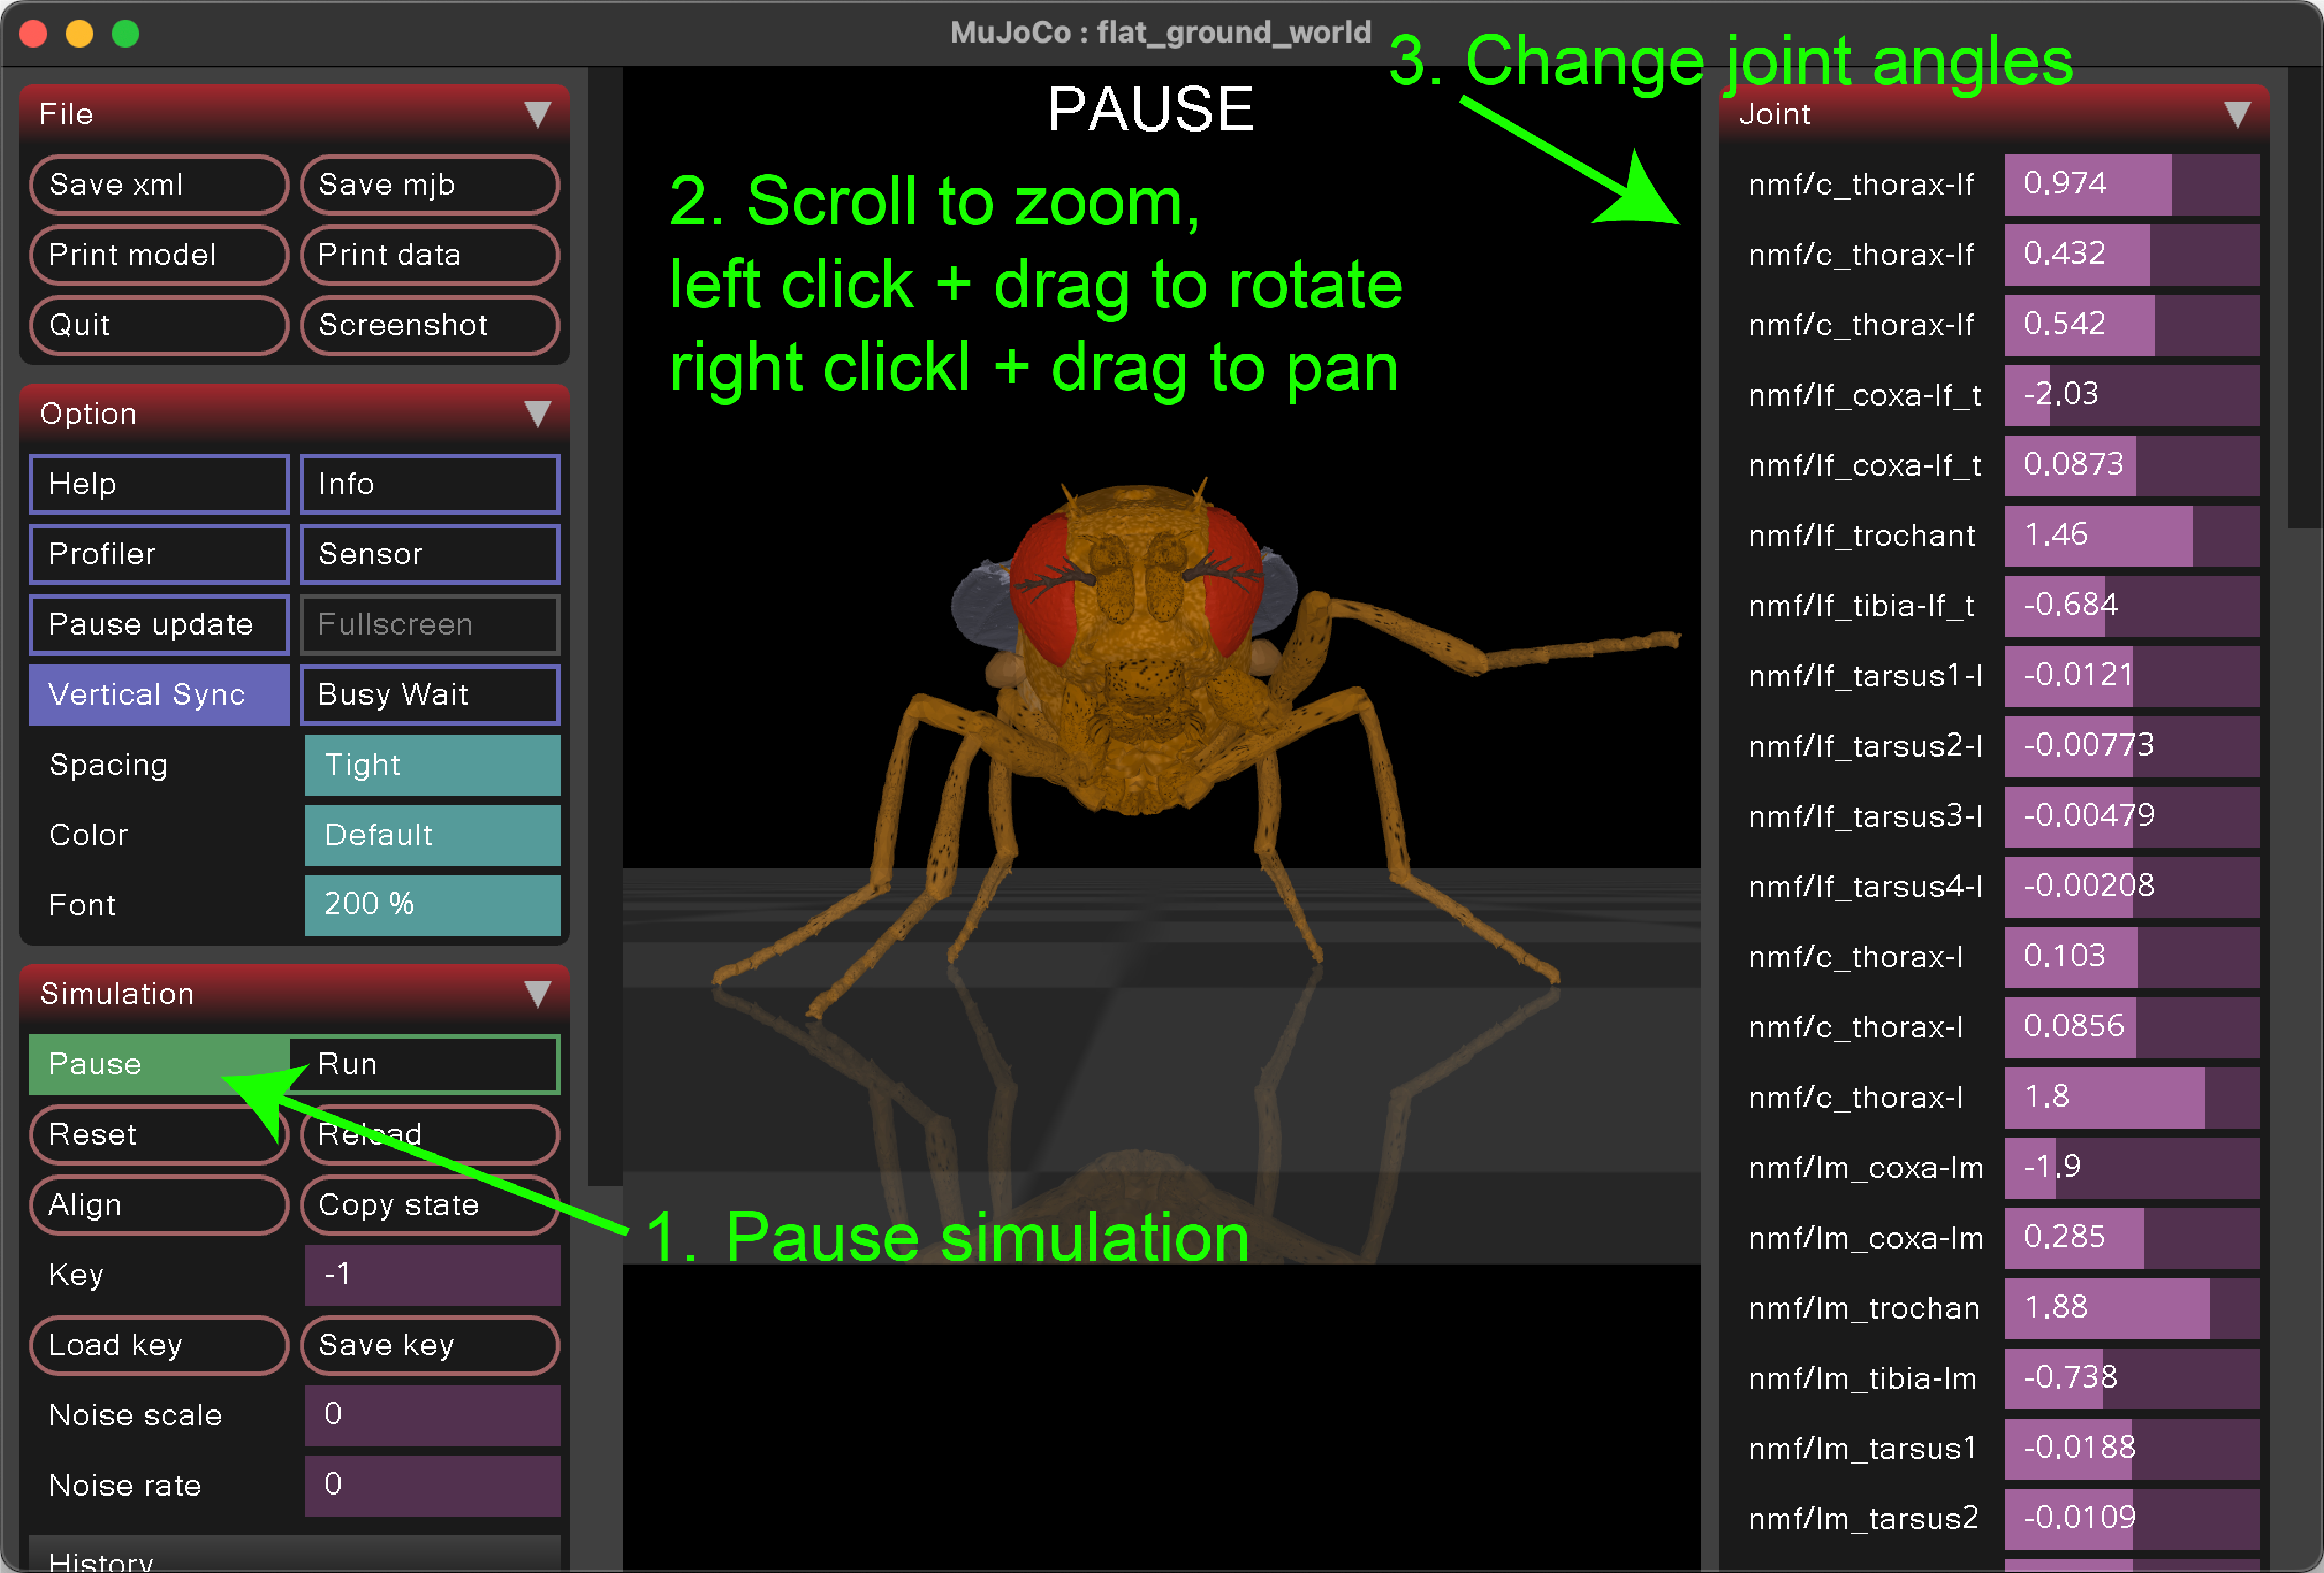

Run the cell below to launch the interactive viewer:

In [ ]:
import os
from flygym.rendering import launch_interactive_viewer

sim = run_simulation()
mj_model, mj_data = sim.world.compile()

if os.environ.get("MUJOCO_GL") == "egl" or os.environ.get("PYOPENGL_PLATFORM") == "egl":
    import warnings

    warnings.warn(
        "EGL detected: skipping interactive viewer launch since it is not supported in headless environments."
    )
else:
    launch_interactive_viewer(mj_model, mj_data, run_async=True)

Adjust the joint angles in the viewer to match the pose shown below (three camera views). Once satisfied, click **"Copy state"** in the Simulation tab on the left panel, then paste the XML string into the code cell below.

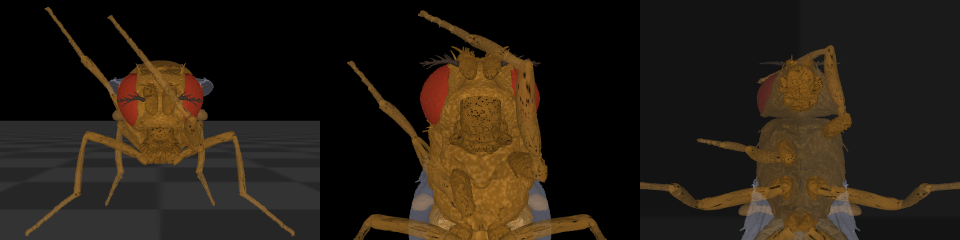

In [ ]:
################################################################################
# TODO: paste the state XML string copied from the interactive viewer
state_xml_string = """
"""
################################################################################


def get_angles_from_xml_string(
    state_xml_string: str, fly: Fly, dof_order: Iterable[str]
) -> np.ndarray:
    """Parse a MuJoCo key-frame XML string and return joint angles in the given DoF order.

    The first 7 values in ``qpos`` (root position + quaternion) are skipped;
    the remaining values correspond to joint DoFs.
    """
    from xml.etree import ElementTree

    root = ElementTree.fromstring(state_xml_string)
    all_angles = [float(v) for v in root.attrib["qpos"].split()[7:]]
    all_dof_names = [dof.name for dof in fly.get_jointdofs_order()]
    return np.array([all_angles[all_dof_names.index(name)] for name in dof_order])


fly = sim.world.fly_lookup["nmf"]
angles_target = get_angles_from_xml_string(state_xml_string, fly, dof_names)

Next, we retrieve the neutral (resting) pose angles, define the keyframe sequence, and linearly interpolate between them:

In [ ]:
# Get neutral (resting) pose angles
pose = KinematicPose(path=assets_dir / "model/pose/neutral.yaml")
angles_dict = pose.get_angles_lookup(axis_order=AxisOrder.YAW_PITCH_ROLL)
angles_neutral = np.array([angles_dict[name] for name in dof_names])

# Interpolate: neutral → target pose → mirrored target pose
dof_angles_sequence = interpolate_dof_angles(
    [angles_neutral, angles_target, angles_target[flipped_idx]],
    original_timestep=0.2,
    new_timestep=sim_timestep,
)

Run the simulation with a front-facing camera:

In [ ]:
# Front-facing tracking camera
camera_kwargs = {
    "pos_offset": (7.5, 0, 0),
    "rotation": Rotation3D("xyaxes", (0, 1, 0, 0, 0, 1)),
    "mode": "track",
}

sim = run_simulation(
    dof_angles=dof_angles_sequence,
    dof_names=dof_names,
    camera_kwargs=camera_kwargs,
)
show_video(sim)